## Post Sentiment Classification Task

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

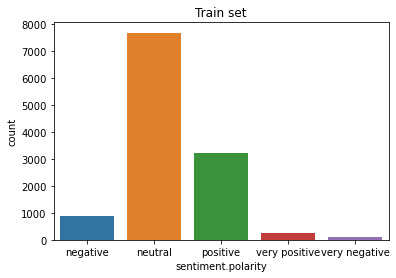

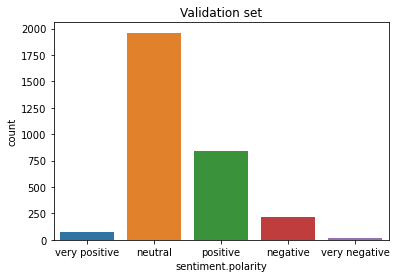

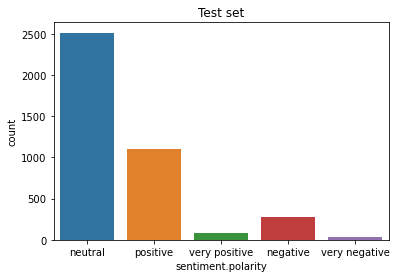

In [5]:
a=0
datasets = [train_data, validation_data, test_data] 
titles = ['Train set','Validation set','Test set']
for i in datasets:
    plt.title(titles[a])
    sns.countplot( x= 'sentiment.polarity', data = i)
    plt.show()
    a+=1

Length of each data set

In [6]:
a= 0 
for i in datasets:
    print('{} contains {} reviews'.format(titles[a],len(i)))
    print('The distribution of reviews are as follows,')
    print(i['sentiment.polarity'].value_counts())
    print('\n')
    a+=1

Train set contains 12138 reviews
The distribution of reviews are as follows,
neutral          7679
positive         3231
negative          878
very positive     253
very negative      97
Name: sentiment.polarity, dtype: int64


Validation set contains 3109 reviews
The distribution of reviews are as follows,
neutral          1961
positive          845
negative          215
very positive      73
very negative      15
Name: sentiment.polarity, dtype: int64


Test set contains 4016 reviews
The distribution of reviews are as follows,
neutral          2514
positive         1102
negative          282
very positive      86
very negative      32
Name: sentiment.polarity, dtype: int64




In [14]:
import spacy

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner','lemmatizer'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Tokenize and Normalize

In [15]:
#Tokenize
def spacy_tokenize(string):
    tokens = list()
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

#Normalize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
            normalized_tokens.append(normalized)
    return normalized_tokens

#Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

In [18]:
train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444
...,...,...,...,...,...,...,...,...,...,...,...,...
12133,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpyd0,https://www.reddit.com/r/reddit.com/comments/h...,,"If you were God, you'd know whether we would b...",answer,False,1,t3_hzu51,neutral,0.000000
12134,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpz7m,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,If I check my account balance in 5 minutes and...,answer,False,1,t3_hzu51,neutral,0.000000
12135,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq0tl,https://www.reddit.com/r/reddit.com/comments/h...,alllie,I don't know. Can you heal the sick with a tou...,answer,False,1,t3_hzu51,negative,0.637202
12136,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq19j,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,... Give LeBron James a championship ring?,humor,False,2,t1_c1zq0tl,neutral,0.000000


Count Vectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])

# This creates input features for our classification on all subsets of our collection.
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

Label Encoding

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(train_data['sentiment.polarity'])
validation_labels = le.transform(validation_data['sentiment.polarity'])
test_labels = le.transform(test_data['sentiment.polarity'])

Dummy Classifier